In [2]:
import sys
import os
import subprocess
import os
import numpy as np
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path+"/detectors")
from detectors import Body, render_from_candidate_and_subset

In [3]:
def find_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

def run_command(input_file):
    # 运行子命令并返回 stdout 和 stderr
    command = ["./build/detectors_bridge", input_file]
    result = subprocess.run(command, capture_output=True, text=True, cwd="..")
    return result.stdout, result.stderr

def test_openpose(directory):
    image_files = find_image_files(directory)
    for image_file in image_files:
        print(f"Processing file: {image_file}")
        stdout, stderr = run_command(f"scripts/{image_file}")
        print(f"stdout: {stdout}")
        print(f"stderr: {stderr}")

In [ ]:
test_openpose("media")

In [4]:
## python side
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y
        
def resize_image(input_image, resolution):
    import cv2
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img


def preprocess(input_image, detect_resolution=512,):
    input_image = np.array(input_image)
    input_image = HWC3(input_image)
    input_image = resize_image(input_image, detect_resolution)
    H, W, C = input_image.shape
    print(input_image.shape)

    # RGB -> BGR or BGR -> RGB
    # the openpose model must read from BGR?
    img = input_image[:, :, ::-1].copy()
    return img

# if missing this, download from https://huggingface.co/lllyasviel/ControlNet/blob/main/annotator/ckpts/body_pose_model.pth
body_model_path = "body_pose_model.pth" 

body_estimation = Body(body_model_path)

In [8]:
def verify_pose_result(directory):
    results = []
    image_files = find_image_files(directory)
    for image_file in image_files:
        with Image.open(image_file) as img:
            W, H = img.size
            if os.path.exists(f"{image_file}.candidate.txt") and os.path.exists(f"{image_file}.subset.txt"):
                print(f"Verifying: {image_file}")
                try:
                    candidate = np.loadtxt(f"{image_file}.candidate.txt")
                    subset = np.loadtxt(f"{image_file}.subset.txt")
                    if len(subset.shape) == 1:
                        subset = np.expand_dims(subset, axis=0)
                    # print(f"candidate.shape: {candidate.shape}")
                    # print(f"subset.shape: {subset.shape}")
                    py_input = preprocess(img)
                    py_candidate, py_subset = body_estimation(py_input)
                    
                    pose_img = render_from_candidate_and_subset(candidate, subset, H, W)
                    py_pose_img = render_from_candidate_and_subset(py_candidate, py_subset, H, W)
                    results.append({"file": image_file, "image": img, "cpp_result": pose_img, "py_result": py_pose_img})
                except Exception as e:
                    print(e)
                    print(f"{image_file} no result")
    return results

results = verify_pose_result("media")

Verifying: media/COCO_val2014_000000000459.jpg
(640, 512, 3)
Verifying: media/COCO_val2014_000000000623.jpg
(704, 512, 3)
Verifying: media/COCO_val2014_000000000257.jpg
(512, 704, 3)
Verifying: media/COCO_val2014_000000000536.jpg
(512, 704, 3)
Verifying: media/COCO_val2014_000000000192.jpg
(512, 704, 3)
Verifying: media/COCO_val2014_000000000241.jpg
(704, 512, 3)
Verifying: media/COCO_val2014_000000000428.jpg
(512, 896, 3)
Verifying: media/COCO_val2014_000000000415.jpg
(896, 512, 3)
Verifying: media/COCO_val2014_000000000544.jpg
(512, 768, 3)
Verifying: media/COCO_val2014_000000000338.jpg
(512, 1024, 3)
Verifying: media/COCO_val2014_000000000357.jpg
(512, 1472, 3)
Verifying: media/COCO_val2014_000000000474.jpg
(768, 512, 3)
Verifying: media/COCO_val2014_000000000360.jpg
(512, 704, 3)


/tmp/ipykernel_3626664/175167731.py:10: UserWarning: loadtxt: input contained no data: "media/COCO_val2014_000000000360.jpg.candidate.txt"
  candidate = np.loadtxt(f"{image_file}.candidate.txt")
/tmp/ipykernel_3626664/175167731.py:11: UserWarning: loadtxt: input contained no data: "media/COCO_val2014_000000000360.jpg.subset.txt"
  subset = np.loadtxt(f"{image_file}.subset.txt")


index 18 is out of bounds for axis 0 with size 0
media/COCO_val2014_000000000360.jpg no result
Verifying: media/COCO_val2014_000000000294.jpg
(512, 768, 3)
Verifying: media/COCO_val2014_000000000488.jpg
(512, 832, 3)
Verifying: media/COCO_val2014_000000000328.jpg
(512, 640, 3)
Verifying: media/COCO_val2014_000000000569.jpg
(512, 704, 3)
Verifying: media/COCO_val2014_000000000564.jpg
(640, 512, 3)
Verifying: media/COCO_val2014_000000000589.jpg
(512, 704, 3)
Verifying: media/COCO_val2014_000000000395.jpg
(512, 576, 3)


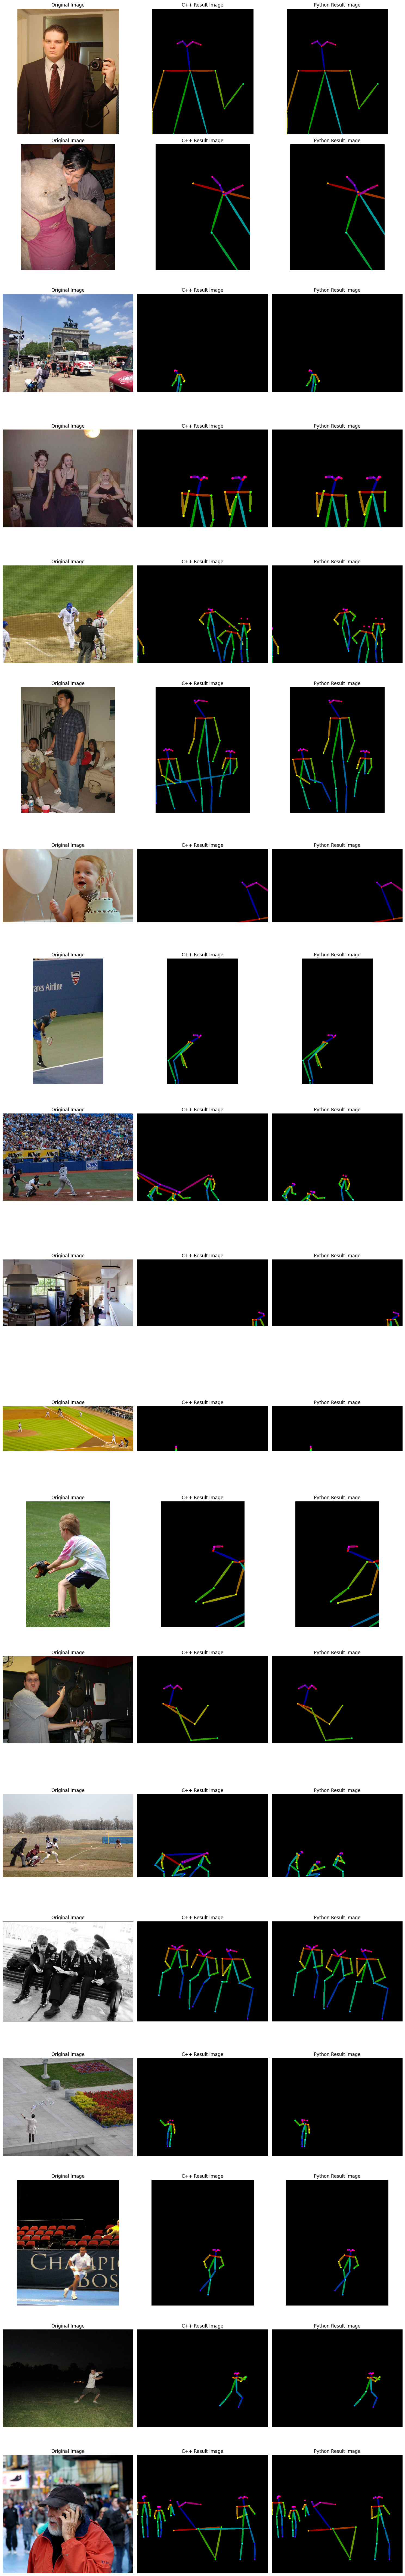

In [9]:
def display_images(data_list):
    num_images = len(data_list)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for i, data in enumerate(data_list):
        img = data["image"]
        cpp_result = data["cpp_result"]
        py_result = data["py_result"]
        
        if num_images == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Display original image
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        # Display C++ result image
        ax[1].imshow(cpp_result)
        ax[1].set_title("C++ Result Image")
        ax[1].axis('off')
        
        # Display Python result image
        ax[2].imshow(py_result)
        ax[2].set_title("Python Result Image")
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()

display_images(results)